# XGBoost Model with All Features after initial preprocessing

## Objective of this model is to refine our feature selection and reduce dimensionality of the binary task

In [1]:
import pandas as pd
composite_preprocessed = pd.read_csv('Composite_preprocessed_NO_MV_BALANCED.csv')
composite_preprocessed.head()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year,Detected by Transits
0,3.094076,-0.666894,0.0,2.424559,1.234306,-0.145901,-0.624689,0.613405,1.731519,-0.261600,-0.012466,-0.044364,0,0,2007,0
1,-0.256668,-0.666894,0.0,1.186720,-0.283545,1.148661,-0.992906,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2009,0
2,-0.256668,-0.666894,0.0,-0.877523,-0.306068,0.308947,-2.327878,0.613405,0.729626,-0.261600,-0.012466,-0.044364,0,0,2008,0
3,-0.256668,0.216988,0.0,1.382856,-0.669803,0.872499,-0.152934,0.613405,3.735304,0.591749,-0.012466,-0.044364,0,0,2002,0
4,6.444820,-0.666894,0.0,0.261241,-0.531444,1.023143,0.855489,0.613405,3.735304,2.298449,-0.012466,-0.044364,0,0,1996,0


# Train Test Split

In [2]:
# we are trying to predict whether an exoplanet has been detected by transits (0= False, 1= True)
targets = composite_preprocessed['Detected by Transits']
# training features are all variables except the target variable
features = composite_preprocessed.drop(['Detected by Transits'], axis=1)

## Observe Feature Correlations

In [3]:
features.corr()

,Number of Stars,Number of Planets,Number of Moons,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements,Circumbinary Flag,Controversial Flag,Discovery Year
Number of Stars,1.000000,0.109074,NaN,-0.044988,0.104236,-0.087528,-0.069450,0.057734,0.132503,0.077689,-0.003200,-0.002096,0.244685,0.090915,-0.147575
Number of Planets,0.109074,1.000000,NaN,-0.055511,0.008589,0.026680,-0.023926,-0.002505,0.082470,0.186263,0.057797,0.076409,-0.012547,0.061726,-0.072274
Number of Moons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Galactic Latitude [deg],-0.044988,-0.055511,NaN,1.000000,-0.019213,0.463063,0.174632,-0.090369,-0.047292,-0.058085,-0.025691,-0.008918,0.009070,-0.016991,0.031820
Galactic Longitude [deg],0.104236,0.008589,NaN,-0.019213,1.000000,-0.657044,-0.408779,0.131333,0.113682,0.054698,-0.008283,-0.026088,0.025643,0.020641,-0.106558
Ecliptic Latitude [deg],-0.087528,0.026680,NaN,0.463063,-0.657044,1.000000,0.498442,-0.222283,-0.139970,-0.104345,-0.006864,0.025212,-0.028239,-0.013646,0.081113
Ecliptic Longitude [deg],-0.069450,-0.023926,NaN,0.174632,-0.408779,0.498442,1.000000,-0.119612,-0.191094,-0.193637,0.013811,0.031078,0.001673,0.000296,0.058041
Number of Photometry Time Series,0.057734,-0.002505,NaN,-0.090369,0.131333,-0.222283,-0.119612,1.000000,0.174390,0.182466,-0.004172,-0.014848,-0.022719,0.008973,-0.252983
Number of Radial Velocity Time Series,0.132503,0.082470,NaN,-0.047292,0.113682,-0.139970,-0.191094,0.174390,1.000000,0.492154,-0.003394,-0.007912,-0.019551,-0.006469,-0.498031
Number of Stellar Spectra Measurements,0.077689,0.186263,NaN,-0.058085,0.054698,-0.104345,-0.193637,0.182466,0.492154,1.000000,-0.003261,-0.011606,-0.019001,0.020205,-0.244466


# Random seed for reproducability

### Every time we use random_state=42 it will shuffle the same random way

In [4]:
import random
import numpy as np
import xgboost as xgb

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    xgb.set_config(verbosity=0) # silent verbosity to reduce output clutter

set_random_seed(42)

## Split data

In [5]:
# Splitting dataset into training, testing and validation addresses overfitting
# shuffling is necessary to remove dependencies that come from order of data


# 80:10:10 split ; Training ; Validation ; Testing
# so we split twice; once into 80:20, then 50:50 (so 50% of the designated testing portion is for validation)

# first split
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(features, targets, test_size = 0.2, random_state = 42, shuffle=True)

# second split
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42, shuffle=True)

# Fitting the XGBoost Model

In [6]:
# we use logloss (cross-entropy loss) since it measures performance of a classification model where output is probability btwn 0-1
# very suitable for binary classification problems

# logloss penalizes incorrect predictions more strongly than correct ones (penalty increases as predicted probability diverges from actual class label 0 or 1)
# robust metric for binary classification as it considers correctness of predictions and CONFIDENCE of those predictions

# logloss works with probability scores (outputs of models like logistic regression and XGBoost)
# this is useful bc XGBoost outputs probability scores for the positive class, and logloss is a natural way to evaluate these probabilities

# logloss is also continuous and differentiable (Great for optimizing)
# XGBoost uses gradient boosting, logloss provides smooth gradient for updates 

xgb_model_all = xgb.XGBClassifier(eval_metric = 'logloss')


# XGBoost models can't have [, ] or < characters in feature names
# One or more of these characters are present in our features (ex: Ecliptic Latitude [deg])
# Use lambda to rename features and run the model

x_train_clean = x_train.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', ''))
x_test_clean = x_test.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', ''))
x_val_clean = x_val.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('<', '').replace('>', ''))

# incorporate early_stopping_rounds to save time and computational resources if model performance is unlikely to improve further
# model stops training if no improvement in the validation set for 10 rounds in a row 
# prevents ovefitting and makes training more efficient
xgb_model_all.fit(x_train_clean, y_train, eval_set=[(x_val_clean, y_val)], early_stopping_rounds=10)

[0]	validation_0-logloss:0.49569
[1]	validation_0-logloss:0.38645
[2]	validation_0-logloss:0.31645
[3]	validation_0-logloss:0.27012
[4]	validation_0-logloss:0.23686
[5]	validation_0-logloss:0.21144
[6]	validation_0-logloss:0.19418
[7]	validation_0-logloss:0.17966
[8]	validation_0-logloss:0.17057
[9]	validation_0-logloss:0.16355
[10]	validation_0-logloss:0.15748
[11]	validation_0-logloss:0.15143
[12]	validation_0-logloss:0.15008
[13]	validation_0-logloss:0.14749
[14]	validation_0-logloss:0.14613
[15]	validation_0-logloss:0.14351
[16]	validation_0-logloss:0.14083
[17]	validation_0-logloss:0.14130
[18]	validation_0-logloss:0.14120
[19]	validation_0-logloss:0.13921


/Users/kevin/anaconda3/envs/py310_ds/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-logloss:0.13859
[21]	validation_0-logloss:0.13799
[22]	validation_0-logloss:0.13761
[23]	validation_0-logloss:0.13518
[24]	validation_0-logloss:0.13538
[25]	validation_0-logloss:0.13597
[26]	validation_0-logloss:0.13450
[27]	validation_0-logloss:0.13339
[28]	validation_0-logloss:0.13444
[29]	validation_0-logloss:0.13563
[30]	validation_0-logloss:0.13598
[31]	validation_0-logloss:0.13536
[32]	validation_0-logloss:0.13266
[33]	validation_0-logloss:0.13098
[34]	validation_0-logloss:0.13117
[35]	validation_0-logloss:0.13134
[36]	validation_0-logloss:0.13230
[37]	validation_0-logloss:0.13201
[38]	validation_0-logloss:0.13197
[39]	validation_0-logloss:0.13335
[40]	validation_0-logloss:0.13216
[41]	validation_0-logloss:0.13111
[42]	validation_0-logloss:0.12987
[43]	validation_0-logloss:0.12893
[44]	validation_0-logloss:0.12880
[45]	validation_0-logloss:0.12895
[46]	validation_0-logloss:0.12758
[47]	validation_0-logloss:0.12669
[48]	validation_0-logloss:0.12602
[49]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

## Predict on the test set

### See the actual predictions of the model on the test set

In [7]:
y_pred_xgb_all = xgb_model_all.predict(x_test_clean)
y_pred_xgb_all

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,

# Performance Metrics

In [8]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb_all)
xgb_all_accuracy = accuracy_score(y_test, y_pred_xgb_all)
classif_report = classification_report(y_test, y_pred_xgb_all)
roc_score = roc_auc_score(y_test, y_pred_xgb_all)

print(
    cm,
    '\nXGB ALL Accuracy on Test Set:', xgb_all_accuracy,
    '\nXGB ALL Classification Report on Test Set:\n', classif_report,
    '\nXGB ALL ROC AUC Score on Test Set:\n', roc_score) 

[[319  15]
 [  8 302]] 
XGB ALL Accuracy on Test Set: 0.9642857142857143 
XGB ALL Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       334
           1       0.95      0.97      0.96       310

    accuracy                           0.96       644
   macro avg       0.96      0.96      0.96       644
weighted avg       0.96      0.96      0.96       644
 
XGB ALL ROC AUC Score on Test Set:
 0.9646416843731891


## Test set ROC AUC score 

In [9]:
y_prob_xgb_all = xgb_model_all.predict_proba(x_test_clean)[:,1]
roc_auc_xgb_all = roc_auc_score(y_test, y_prob_xgb_all)

('ROC AUC Score All Features:', roc_auc_xgb_all)

('ROC AUC Score All Features:', 0.9859088275062778)

## K-Fold Cross validation score

In [10]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_all = cross_val_score(xgb_model_all, x_train_clean, y_train, cv=kf, scoring = 'accuracy')
roc_auc_scores_all = cross_val_score(xgb_model_all, x_train_clean, y_train, cv=kf, scoring=make_scorer(roc_auc_score, needs_proba=True))

(f"Cross-Validation Accuracy Scores: {cv_scores_all}"),(f"Mean CV Accuracy: {cv_scores_all.mean()}"),(f"Cross-Validation ROC-AUC Scores: {roc_auc_scores_all}"),(f"Mean CV ROC-AUC: {roc_auc_scores_all.mean()}")

('Cross-Validation Accuracy Scores: [0.96893204 0.97572816 0.96699029 0.95918367 0.96793003]',
 'Mean CV Accuracy: 0.96775283761216',
 'Cross-Validation ROC-AUC Scores: [0.99190014 0.9953335  0.99279059 0.99087488 0.99443981]',
 'Mean CV ROC-AUC: 0.9930677851212544')

## Feature Importance Table
### (Importance type = weight)

In [11]:
importance_type = 'weight'

# extract importance of type weight from the xgb model 
feature_importances = xgb_model_all.get_booster().get_score(importance_type = importance_type) 

# extract feature names
feature_names = x_train.columns


# create pd df with the extracted information and sort features by importance (type =  weight)
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns = ['Features', 'Importance']).sort_values(by='Importance', ascending=False)

feature_importance_df

,Features,Importance
4,Ecliptic Latitude deg,271.0
2,Galactic Latitude deg,250.0
3,Galactic Longitude deg,223.0
5,Ecliptic Longitude deg,201.0
11,Discovery Year,132.0
1,Number of Planets,78.0
6,Number of Photometry Time Series,32.0
0,Number of Stars,20.0
7,Number of Radial Velocity Time Series,17.0
8,Number of Stellar Spectra Measurements,14.0


## Plot Feature Importance

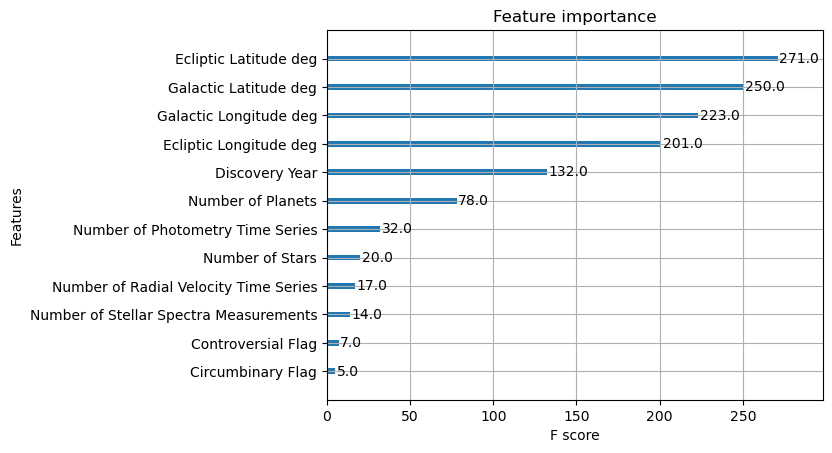

In [12]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model_all)
plt.show()

## F Score (weight) in this context represents the frequency in which a feature is used in the splits of the trees across the entire ensemble
### Frequency refers to the number of times a feature is used to split the data across all trees in the model
### Higher F score means a feature is used more frequently to create decision points (splits) in the trees, indicating the feature is considered important by the model

## Based on the table and plot, an F score threshold of 30 is appropriate 
### We will exclude features that scored less than 30 in the refined features XGBoost training to retain only the most significant features and reduce overall complexity
## Features to Keep:
### 4   Ecliptic Latitude deg	271.0
### 2	Galactic Latitude deg	250.0
### 3	Galactic Longitude deg	223.0
### 5	Ecliptic Longitude deg	201.0
### 11	Discovery Year	132.0
### 1	Number of Planets	78.0
### 6	Number of Photometry Time Series	32.0

## Features to Exclude:
### 0	Number of Stars	20.0
### 7	Number of Radial Velocity Time Series	17.0
### 8	Number of Stellar Spectra Measurements	14.0
### 10	Controversial Flag	7.0
### 9	Circumbinary Flag	5.0